<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os, random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Concatenate, Dense, Dropout, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Conv1D, GRU, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [36]:
SEMENTE = 2008193

LIMITE_DICIONARIO = 80000

MAXIMO_MODELOS = 20

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 32
NUCLEO_TAMANHO = 64
PREENCHIMENTO = 'same'

NEURONIOS_DENSO = 128
ABANDONOS = 0.1

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

## Dados

Fake.Br Corpus https://github.com/roneysco/Fake.br-Corpus

In [4]:
dados = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',
                    index_col=['index'])

In [5]:
dados['label'].replace({'fake': 0, 'true': 1}, inplace=True)

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   int64 
 1   preprocessed_news  7200 non-null   object
dtypes: int64(1), object(1)
memory usage: 168.8+ KB


In [7]:
dados

,label,preprocessed_news
index,,
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,1,jornal britanico acao contra lula lava jato se...
7196,1,temer diz acionou pf cade investigar aumentos ...
7197,1,obstaculos politicos temer especialistas ouvid...


In [8]:
dados['label'].value_counts()

0    3600
1    3600
Name: label, dtype: int64

In [9]:
X = dados['preprocessed_news']
y = dados['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEMENTE)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760,), (1440,), (5760,), (1440,))

In [11]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(dtype('O'), dtype('O'), dtype('int64'), dtype('int64'))

### Converter texto em números

In [12]:
# media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

# tamanho_texto = media_palavras_por_texto
tamanho_texto = maximo_palavras_por_texto

#### Vetorização (Vectorization)

In [13]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [14]:
vetorizador.adapt(X_train)

In [15]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

saiba presidenciavel conquistando votos eleitores ensino superior instituto parana pesquisas surpreendeu analistas politicos revelacao presidenciavel conquistando eleitores ensino superior surpreendente resultado pode indicar reviravolta todos outros grupos supremo tribunal federal joaquim barbosa preferido eleicoes presidenciais eleitores ensino superior mostra estudo inedito instituto parana pesquisas segundo levantamento barbosa intencoes voto desta parcela populacao lula vem segundo jair bolsonaro terceiro quarto aecio neves pesquisa surpreendente revelar deputado jair bolsonaro tambem crescendo eleitores nivel superior antes crescimento so percebido eleitores escolaridade media fundamental importante destacar bolsonaro tambem bem frente politicos participaram outras disputas eleitorais tais dilma rousseff marina silva ciro gomes cristovam buarque ronaldo caiado joaquim barbosa fortemente cotado ser chapa marina silva rede sustentabilidade entanto ascensao vertiginosa pode vir cand

<tf.Tensor: shape=(1, 4229), dtype=int64, numpy=array([[ 1889,  5221, 21366, ...,     0,     0,     0]])>

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(73258,
 ['', '[UNK]', 'nao', 'lula', 'ser'],
 ['aapesar', 'aachen', 'aace', 'aabertura', 'aabb'])

#### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [19]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

luciano huck apaga todas fotos aecio neves redes sociais internautas nao perdoaram luciano huck apos apresentador deletar todas fotos aparecia senador aecio neves redes sociais fato nao passou desapercebido huck sido apontado candidato globo nao quer nome vinculado nome aecio apos recente escandalo envolvendo nome senador empresario joesley batista grupo assessoria global ainda nao posicionou sobre fato


<tf.Tensor: shape=(1, 4229, 128), dtype=float32, numpy=
array([[[-0.04575515, -0.0071987 , -0.01981586, ..., -0.01950511,
          0.0249755 , -0.03561609],
        [ 0.02192713,  0.00739287, -0.0265514 , ...,  0.00367923,
          0.04021473,  0.00839262],
        [ 0.01853123,  0.04902546, -0.02902591, ..., -0.03818363,
         -0.03178461,  0.00172557],
        ...,
        [ 0.02875349, -0.02157506, -0.0116415 , ...,  0.00151151,
         -0.03960607,  0.02375459],
        [ 0.02875349, -0.02157506, -0.0116415 , ...,  0.00151151,
         -0.03960607,  0.02375459],
        [ 0.02875349, -0.02157506, -0.0116415 , ...,  0.00151151,
         -0.03960607,  0.02375459]]], dtype=float32)>

## Funções

In [20]:
def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice])

## Modelos

In [21]:
modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

modelo_numero = 0

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [22]:
modelo_nome = f'modelo_{modelo_numero}_naive_bayes'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.22      0.36       741
           1       0.55      1.00      0.71       699

    accuracy                           0.60      1440
   macro avg       0.77      0.61      0.53      1440
weighted avg       0.77      0.60      0.53      1440



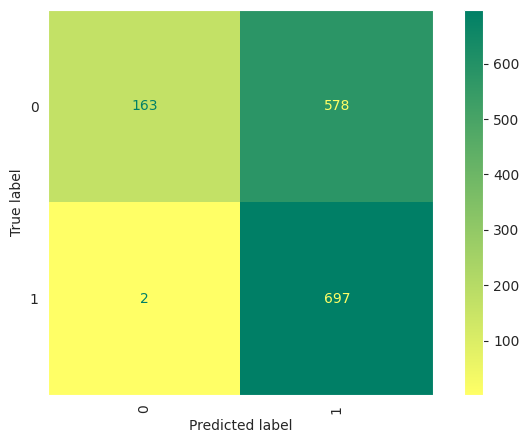

In [24]:
relatorios[modelo_numero] = avaliar_modelo(y_test, previsoes[modelo_numero])

In [25]:
relatorios[modelo_numero]

{'acuracia': 0.5972222222222222,
 'precisao': 0.7737070707070706,
 'revocacao': 0.5972222222222222,
 'pontuacao-f1': 0.5279508332382786}

### Camadas iniciais padronizadas

In [26]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 47.1 ms, sys: 0 ns, total: 47.1 ms
Wall time: 54.5 ms


### Modelo 1: Denso

In [27]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_denso'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 28s 236ms/step - loss: 0.6519 - accuracy: 0.6833 - val_loss: 0.6014 - val_accuracy: 0.8000
Epoch 2/5
90/90 [==============================] - 20s 218ms/step - loss: 0.5078 - accuracy: 0.9267 - val_loss: 0.4289 - val_accuracy: 0.9507
Epoch 3/5
90/90 [==============================] - 22s 243ms/step - loss: 0.3261 - accuracy: 0.9667 - val_loss: 0.2824 - val_accuracy: 0.9549
Epoch 4/5
90/90 [==============================] - 19s 209ms/step - loss: 0.2063 - accuracy: 0.9722 - val_loss: 0.2059 - val_accuracy: 0.9576
Epoch 5/5
90/90 [==============================] - 18s 203ms/step - loss: 0.1431 - accuracy: 0.9783 - val_loss: 0.1665 - val_accuracy: 0.9583
CPU times: user 1min 14s, sys: 1.68 s, total: 1min 16s
Wall time: 2min 24s


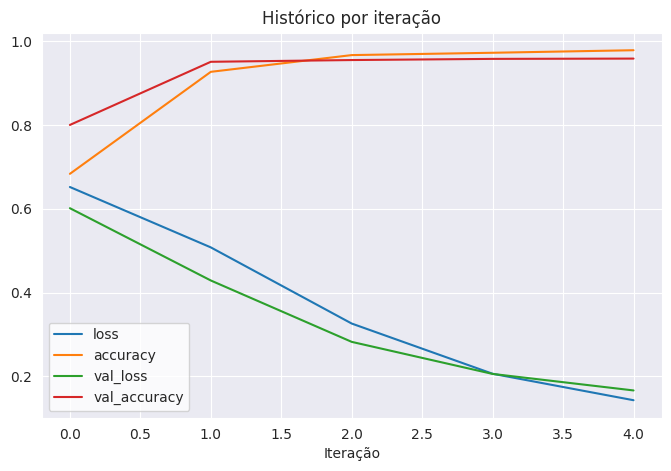

In [28]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       741
           1       0.97      0.95      0.96       699

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



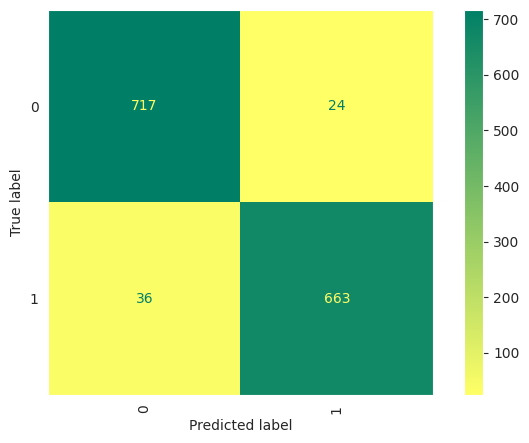

In [29]:
dados_modelo(modelo_numero)

In [30]:
relatorios[modelo_numero]

{'acuracia': 0.9583333333333334,
 'precisao': 0.958440618892697,
 'revocacao': 0.9583333333333334,
 'pontuacao-f1': 0.9583202941636677}

### Modelo 2: LSTM

In [37]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm'

# camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas_iniciais) # Para empilhar camadas recorrentes é necessário return_sequences=True
# camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas)
camadas = LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 32s 327ms/step - loss: 0.6947 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5146
Epoch 2/5
90/90 [==============================] - 27s 298ms/step - loss: 0.6944 - accuracy: 0.5007 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 3/5
90/90 [==============================] - 28s 307ms/step - loss: 0.6937 - accuracy: 0.4944 - val_loss: 0.6929 - val_accuracy: 0.5146
Epoch 4/5
90/90 [==============================] - 26s 287ms/step - loss: 0.6936 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4854
Epoch 5/5
90/90 [==============================] - 27s 298ms/step - loss: 0.6936 - accuracy: 0.5005 - val_loss: 0.6940 - val_accuracy: 0.4854
CPU times: user 1min 56s, sys: 1.5 s, total: 1min 58s
Wall time: 2min 24s


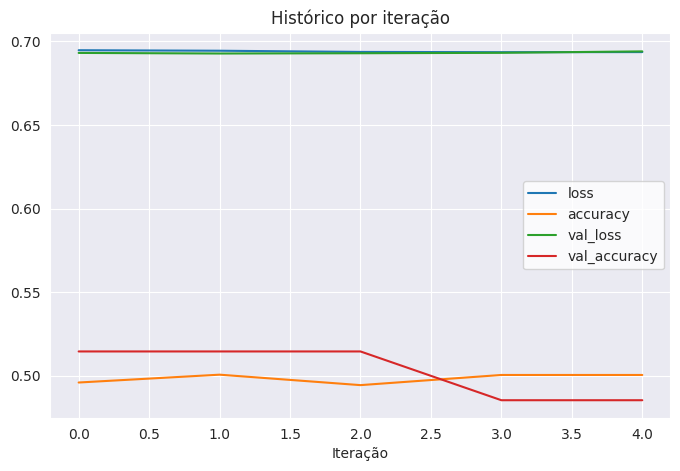

In [38]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 2s 42ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.49      1.00      0.65       699

    accuracy                           0.49      1440
   macro avg       0.24      0.50      0.33      1440
weighted avg       0.24      0.49      0.32      1440



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

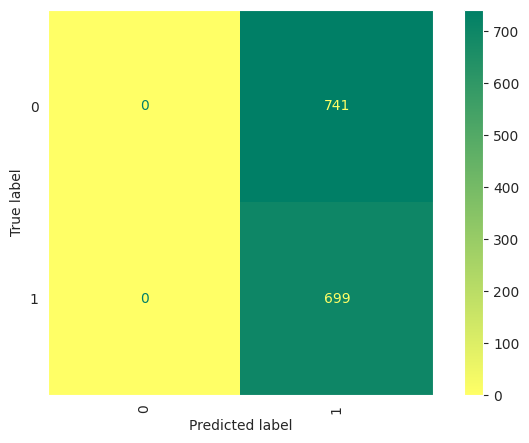

In [39]:
dados_modelo(modelo_numero)

In [40]:
relatorios[modelo_numero]

{'acuracia': 0.48541666666666666,
 'precisao': 0.23562934027777777,
 'revocacao': 0.48541666666666666,
 'pontuacao-f1': 0.31725689574567556}

### Modelo 3: GRU

In [41]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_gru'

# camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True)(camadas_iniciais)
# camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas)
camadas = GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN)(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 32s 323ms/step - loss: 0.6949 - accuracy: 0.5019 - val_loss: 0.6945 - val_accuracy: 0.4854
Epoch 2/5
90/90 [==============================] - 26s 287ms/step - loss: 0.6940 - accuracy: 0.5002 - val_loss: 0.6951 - val_accuracy: 0.4854
Epoch 3/5
90/90 [==============================] - 26s 289ms/step - loss: 0.6938 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4854
Epoch 4/5
90/90 [==============================] - 26s 291ms/step - loss: 0.6938 - accuracy: 0.4939 - val_loss: 0.6970 - val_accuracy: 0.4854
Epoch 5/5
90/90 [==============================] - 25s 279ms/step - loss: 0.6938 - accuracy: 0.5024 - val_loss: 0.6978 - val_accuracy: 0.4854
CPU times: user 1min 56s, sys: 1.42 s, total: 1min 58s
Wall time: 2min 24s


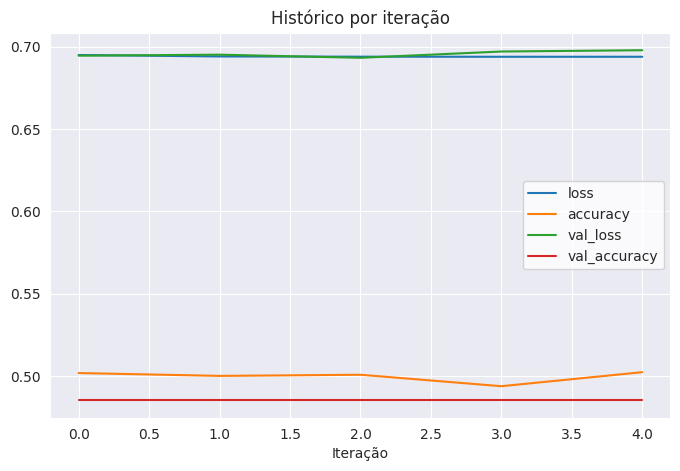

In [42]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 2s 40ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       741
           1       0.49      1.00      0.65       699

    accuracy                           0.49      1440
   macro avg       0.24      0.50      0.33      1440
weighted avg       0.24      0.49      0.32      1440



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

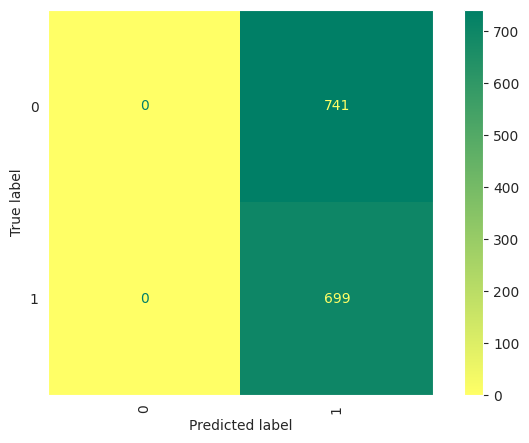

In [43]:
dados_modelo(modelo_numero)

In [44]:
relatorios[modelo_numero]

{'acuracia': 0.48541666666666666,
 'precisao': 0.23562934027777777,
 'revocacao': 0.48541666666666666,
 'pontuacao-f1': 0.31725689574567556}

### Modelo 4: LSTM Bidirecional

In [45]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_lstm_bidirecional'

# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 40s 394ms/step - loss: 0.5001 - accuracy: 0.7514 - val_loss: 0.2356 - val_accuracy: 0.9424
Epoch 2/5
90/90 [==============================] - 33s 371ms/step - loss: 0.1304 - accuracy: 0.9691 - val_loss: 0.1511 - val_accuracy: 0.9521
Epoch 3/5
90/90 [==============================] - 35s 392ms/step - loss: 0.0467 - accuracy: 0.9913 - val_loss: 0.1248 - val_accuracy: 0.9625
Epoch 4/5
90/90 [==============================] - 33s 369ms/step - loss: 0.0179 - accuracy: 0.9977 - val_loss: 0.2023 - val_accuracy: 0.9382
Epoch 5/5
90/90 [==============================] - 31s 349ms/step - loss: 0.0135 - accuracy: 0.9977 - val_loss: 0.1752 - val_accuracy: 0.9535
CPU times: user 2min 39s, sys: 2.62 s, total: 2min 42s
Wall time: 3min 26s


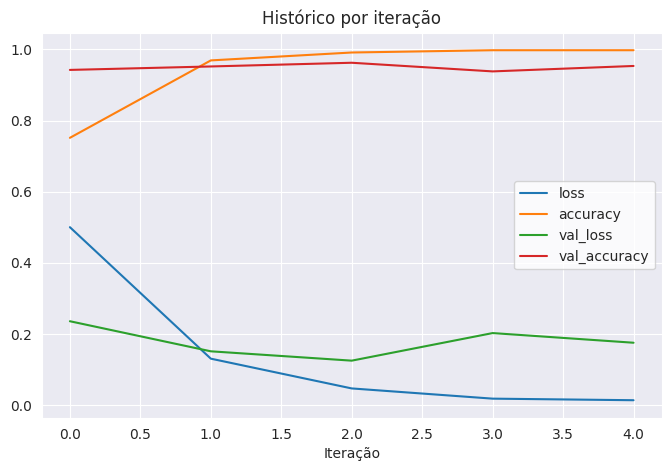

In [46]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 4s 76ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       741
           1       0.94      0.97      0.95       699

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



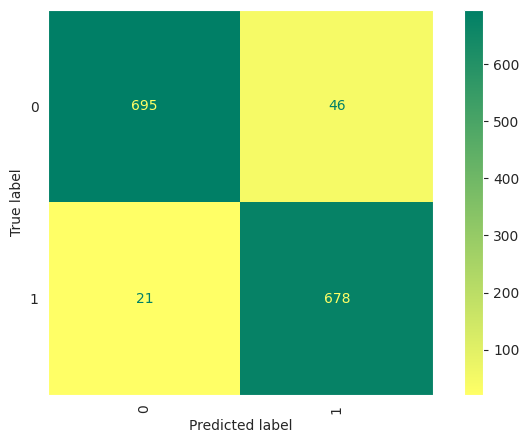

In [47]:
dados_modelo(modelo_numero)

In [48]:
relatorios[modelo_numero]

{'acuracia': 0.9534722222222223,
 'precisao': 0.9540660816434663,
 'revocacao': 0.9534722222222223,
 'pontuacao-f1': 0.9534817597713674}

### Modelo 5: GRU Bidirecional

In [49]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_gru_bidirecional'

# camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=GRU(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 39s 380ms/step - loss: 0.3326 - accuracy: 0.8724 - val_loss: 0.2401 - val_accuracy: 0.9340
Epoch 2/5
90/90 [==============================] - 35s 386ms/step - loss: 0.0438 - accuracy: 0.9884 - val_loss: 0.2718 - val_accuracy: 0.9292
Epoch 3/5
90/90 [==============================] - 33s 366ms/step - loss: 0.0078 - accuracy: 0.9995 - val_loss: 0.2947 - val_accuracy: 0.9187
Epoch 4/5
90/90 [==============================] - 32s 358ms/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.3285 - val_accuracy: 0.9139
Epoch 5/5
90/90 [==============================] - 33s 362ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.3526 - val_accuracy: 0.9014
CPU times: user 2min 38s, sys: 2.43 s, total: 2min 40s
Wall time: 2min 51s


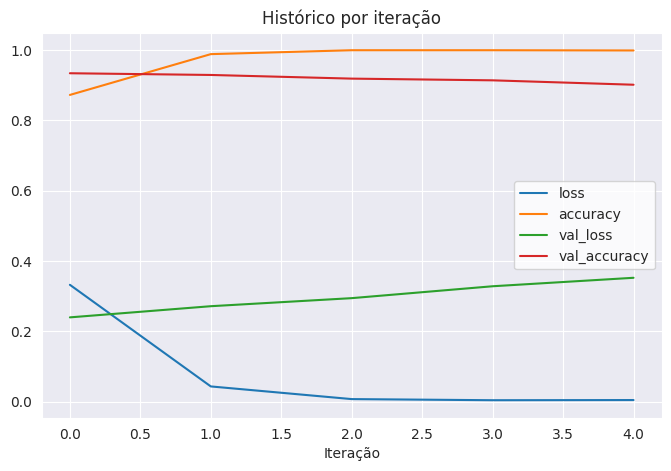

In [50]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 4s 75ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       741
           1       0.88      0.92      0.90       699

    accuracy                           0.90      1440
   macro avg       0.90      0.90      0.90      1440
weighted avg       0.90      0.90      0.90      1440



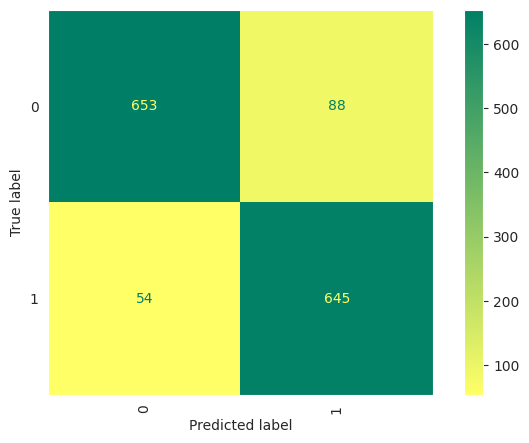

In [51]:
dados_modelo(modelo_numero)

In [52]:
relatorios[modelo_numero]

{'acuracia': 0.9013888888888889,
 'precisao': 0.902420116061499,
 'revocacao': 0.9013888888888889,
 'pontuacao-f1': 0.901401824387584}

### Modelo 6: CNN

In [53]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_cnn'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 27s 213ms/step - loss: 0.1275 - accuracy: 0.9651 - val_loss: 0.1623 - val_accuracy: 0.9396
Epoch 2/5
90/90 [==============================] - 19s 207ms/step - loss: 0.0090 - accuracy: 0.9986 - val_loss: 0.1857 - val_accuracy: 0.9340
Epoch 3/5
90/90 [==============================] - 18s 196ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.2003 - val_accuracy: 0.9326
Epoch 4/5
90/90 [==============================] - 18s 205ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.2071 - val_accuracy: 0.9326
Epoch 5/5
90/90 [==============================] - 17s 189ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.2113 - val_accuracy: 0.9312
CPU times: user 1min 19s, sys: 2.06 s, total: 1min 21s
Wall time: 2min 22s


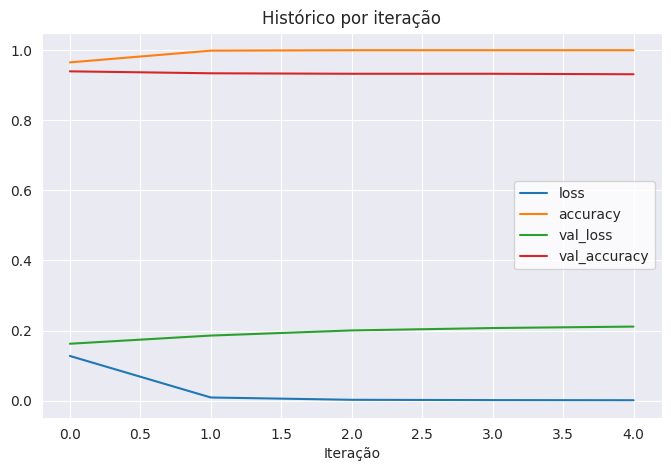

In [54]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       741
           1       0.89      0.97      0.93       699

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.93      0.93      0.93      1440



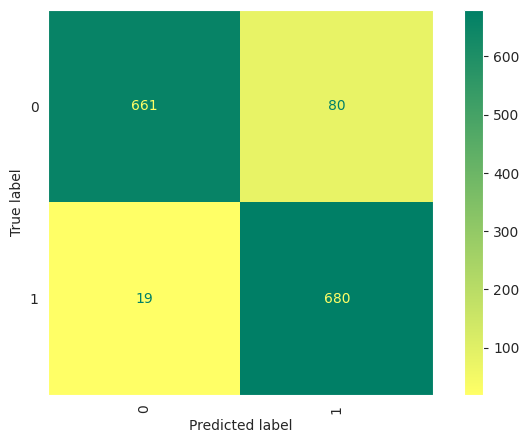

In [55]:
dados_modelo(modelo_numero)

In [56]:
relatorios[modelo_numero]

{'acuracia': 0.93125,
 'precisao': 0.9345254450464396,
 'revocacao': 0.93125,
 'pontuacao-f1': 0.9312115667802892}

### Modelo 7: TFHub Universal Sentence Encoder

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [57]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_tfhub_use'

modelos[modelo_numero] = Sequential(name=modelo_nome)

modelos[modelo_numero].add(hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                          trainable=False,
                                          input_shape=[], # USE aceita textos de tamanho variável.
                                          dtype=ENTRADA_TIPO,
                                          name='camada_use'))

modelos[modelo_numero].add(Dense(ESPACO_SAIDA*2, activation=ATIVACAO_CNN, name='camada_relu'))
modelos[modelo_numero].add(Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida'))

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 18s 157ms/step - loss: 0.3190 - accuracy: 0.9167 - val_loss: 0.1792 - val_accuracy: 0.9326
Epoch 2/5
90/90 [==============================] - 14s 156ms/step - loss: 0.1742 - accuracy: 0.9396 - val_loss: 0.1650 - val_accuracy: 0.9333
Epoch 3/5
90/90 [==============================] - 15s 167ms/step - loss: 0.1650 - accuracy: 0.9411 - val_loss: 0.1682 - val_accuracy: 0.9375
Epoch 4/5
90/90 [==============================] - 16s 175ms/step - loss: 0.1600 - accuracy: 0.9441 - val_loss: 0.1559 - val_accuracy: 0.9396
Epoch 5/5
90/90 [==============================] - 15s 166ms/step - loss: 0.1574 - accuracy: 0.9441 - val_loss: 0.1533 - val_accuracy: 0.9410
CPU times: user 1min 34s, sys: 4.34 s, total: 1min 38s
Wall time: 1min 49s


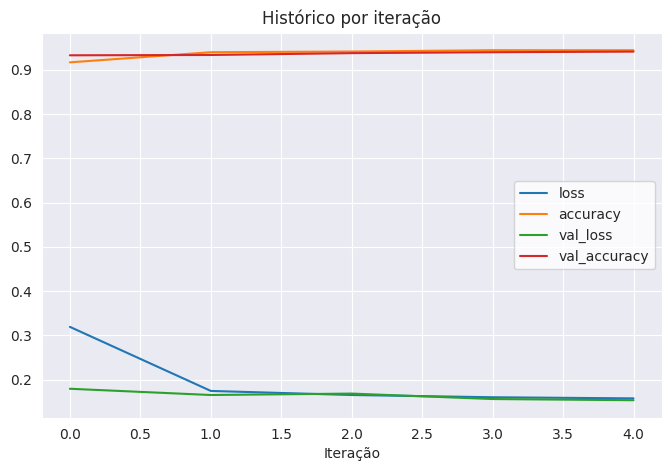

In [58]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 4s 77ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       741
           1       0.94      0.94      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



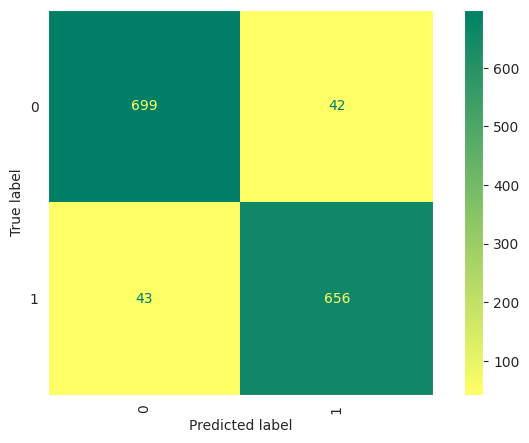

In [59]:
dados_modelo(modelo_numero)

In [60]:
relatorios[modelo_numero]

{'acuracia': 0.9409722222222222,
 'precisao': 0.9409706802518812,
 'revocacao': 0.9409722222222222,
 'pontuacao-f1': 0.9409709970776733}

### Modelo 8: DCNN

In [68]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_dcnn'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=ESPACO_SAIDA, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_test, y_test),
                                                       verbose=1)

Epoch 1/5
90/90 [==============================] - 25s 243ms/step - loss: 0.2804 - accuracy: 0.9278 - val_loss: 0.2027 - val_accuracy: 0.9319
Epoch 2/5
90/90 [==============================] - 21s 231ms/step - loss: 0.0704 - accuracy: 0.9816 - val_loss: 0.1486 - val_accuracy: 0.9465
Epoch 3/5
90/90 [==============================] - 20s 221ms/step - loss: 0.0175 - accuracy: 0.9967 - val_loss: 0.1886 - val_accuracy: 0.9354
Epoch 4/5
90/90 [==============================] - 20s 217ms/step - loss: 0.0048 - accuracy: 0.9998 - val_loss: 0.1719 - val_accuracy: 0.9424
Epoch 5/5
90/90 [==============================] - 18s 206ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1809 - val_accuracy: 0.9431
CPU times: user 1min 21s, sys: 1.63 s, total: 1min 22s
Wall time: 2min 23s


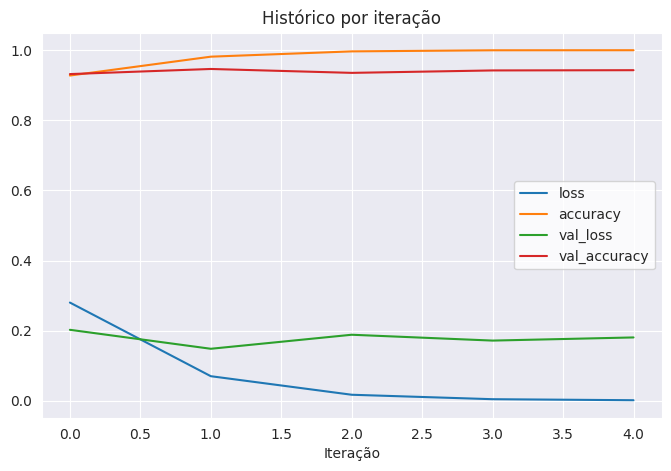

In [69]:
grafico_historico_por_iteracao(historicos[modelo_numero])

45/45 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       741
           1       0.92      0.97      0.94       699

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



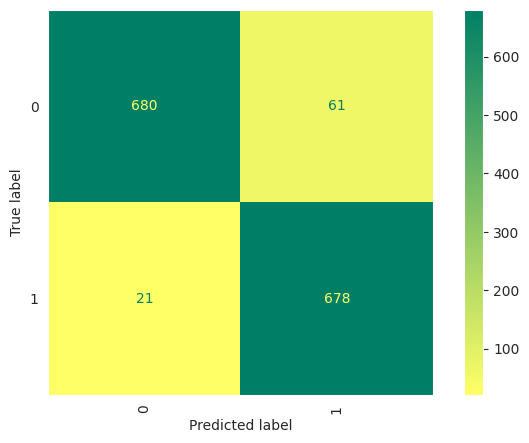

In [70]:
dados_modelo(modelo_numero)

In [71]:
relatorios[modelo_numero]

{'acuracia': 0.9430555555555555,
 'precisao': 0.944516299287634,
 'revocacao': 0.9430555555555555,
 'pontuacao-f1': 0.9430577524905205}

## Comparar modelos

In [72]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

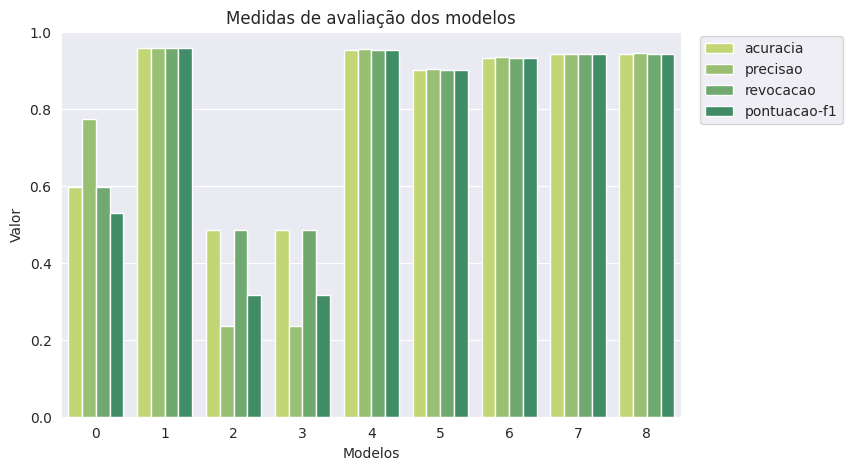

In [73]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));